# Traditional NLP Pipeline for EU Climate Policy Actor Analysis

This notebook implements the Traditional NLP Pipeline for actor tags in EU climate policies, focusing on tags with sufficient observations for supervised learning:

- Addressee_default: 2079 occurrences
- Addressee_sector: 1355 occurrences
- Authority_default: 897 occurrences
- Authority_monitoring: 659 occurrences
- Addressee_monitored: 483 occurrences
- Authority_legislative: 227 occurrences
- Addressee_resource: 142 occurrences

We'll build a pipeline for Named Entity Recognition (NER) and classification of actor types and sectors in EU climate policy text.

## 1. Setup and Data Loading

First, we'll import the necessary libraries and load the POLIANNA dataset.

In [68]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# NLP libraries
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Add project root to path
sys.path.insert(0, '..')
from src.experiment_utils.helper_classes import token, span, repository
from src.d02_corpus_statistics.corpus import Corpus
from definitions import ROOT_DIR

# Set plotting style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except:
    # If model not found, download it
    print("Downloading spaCy model...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

### 1.1 Loading the POLIANNA Dataset

We'll load the preprocessed dataset with annotated spans from the POLIANNA project.

In [69]:
# Load the preprocessed dataframe
dataframe_dir = os.path.join(ROOT_DIR, 'data/preprocessed_dataframe.pkl')
stat_df = pd.read_pickle(dataframe_dir)

# Create corpus object (excluding the preamble sections)
corpus = Corpus(stat_df)

# Display basic information
print(f"Number of documents in corpus: {corpus.df.shape[0]}")
print(f"Number of annotators: {len(corpus.annotators)}")
print(f"Finished annotators: {corpus.finished_annotators}")

Number of documents in corpus: 412
Number of annotators: 7
Finished annotators: ['B', 'F', 'C', 'A']


In [70]:
# Check the first few rows of the dataframe
corpus.df.head(2)

,Policy,Text,Tokens,Article_State,Finished_Annotators,Curation,A,C,F,B,E,G,D
EU_32018R1999_Title_0_Chapter_7_Section_3_Article_43,,article 43\r\nexercise of the delegation\r\n1....,"[token id: T1, start:0 stop:7 text:article tag...",CURATION_FINISHED,"[A, C]",[span id:CUR0 annotator:Curation layer:Instrum...,[span id:A1 annotator:A layer:Instrumenttypes ...,[span id:C1 annotator:C layer:Policydesignchar...,,,,,
EU_32019R0631_Title_0_Chapter_0_Section_0_Article_12,,article 12\r\nreal-world co2 emissions and fue...,"[token id: T459, start:0 stop:7 text:article t...",CURATION_FINISHED,"[F, B]",[span id:CUR36 annotator:Curation layer:Instru...,,,[span id:F1 annotator:F layer:Instrumenttypes ...,[span id:B1 annotator:B layer:Policydesignchar...,,,


### 1.2 Extract Actor Tags from Corpus

Now we'll extract all Actor tags and focus on the seven tag types with sufficient observations.

In [71]:
# Create a general repository to match all documents
all_docs = repository()

# Extract all Actor spans
actor_spans = corpus.get_span_list(
    conditional_rep=all_docs, 
    annotators='Curation', 
    item='feature', 
    value='Actor'
)

print(f"Total number of Actor tags: {len(actor_spans)}")

# Count occurrences of each tag type
tag_counts = {}
for span in actor_spans:
    if span.tag not in tag_counts:
        tag_counts[span.tag] = 0
    tag_counts[span.tag] += 1

# Sort by count (descending)
tag_counts = dict(sorted(tag_counts.items(), key=lambda item: item[1], reverse=True))

# Display counts for each tag type
print("\nActor tag distribution:")
for tag, count in tag_counts.items():
    print(f"{tag}: {count} occurrences")

Total number of Actor tags: 5873

Actor tag distribution:
Addressee_default: 2079 occurrences
Addressee_sector: 1355 occurrences
Authority_default: 897 occurrences
Authority_monitoring: 659 occurrences
Addressee_monitored: 483 occurrences
Authority_legislative: 227 occurrences
Addressee_resource: 142 occurrences
Authority_established: 31 occurrences


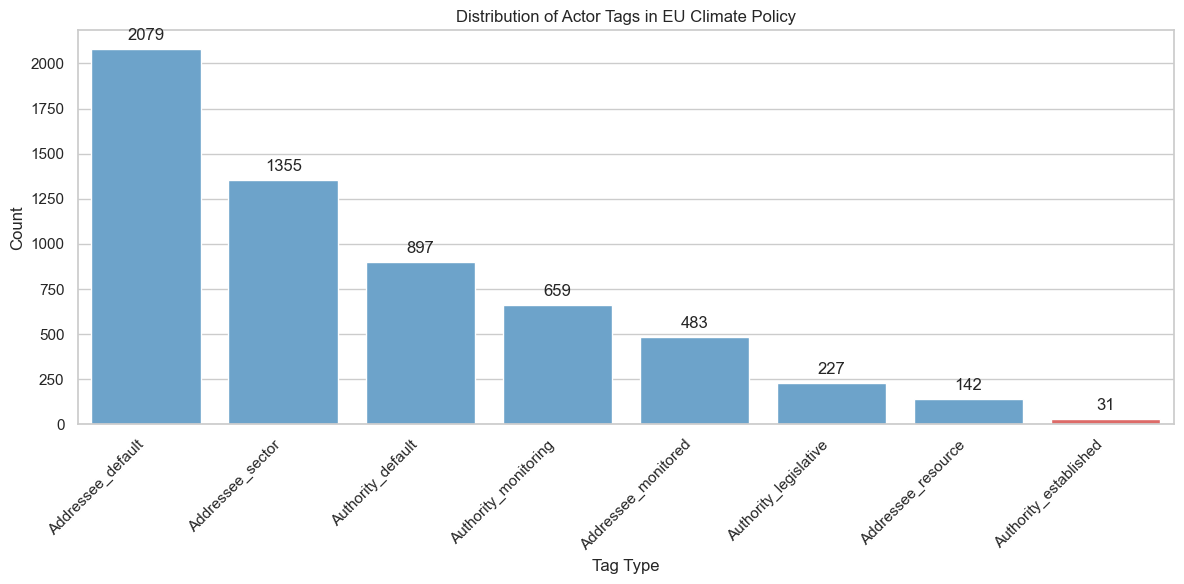

In [72]:
# Define the actor tags suitable for traditional NLP
sufficient_tags = [
    'Addressee_default',
    'Addressee_sector',
    'Authority_default',
    'Authority_monitoring',
    'Addressee_monitored',
    'Authority_legislative',
    'Addressee_resource'
]

# Visualize the distribution of actor tags
plt.figure(figsize=(12, 6))
tags = list(tag_counts.keys())
counts = list(tag_counts.values())
colors = ['#5DA5DA' if tag in sufficient_tags else '#F15854' for tag in tags]

# Create bar plot
ax = sns.barplot(x=tags, y=counts, palette=colors)

# Add count labels on top of bars
for i, count in enumerate(counts):
    ax.text(i, count + 50, f"{count}", ha='center')

plt.title('Distribution of Actor Tags in EU Climate Policy')
plt.xlabel('Tag Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2. Extract Spans for NLP Tasks

We'll extract all spans for the seven actor tags we're focusing on, along with context for better model training.

In [73]:
# Extract spans for each tag type in sufficient_tags
all_spans = []

for tag in sufficient_tags:
    # Get spans for this specific tag
    tag_spans = corpus.get_span_list(
        conditional_rep=all_docs,
        annotators='Curation',
        item='tag',
        value=tag
    )
    
    # Extract relevant information and add context
    for span in tag_spans:
        # Get the document text from the dataframe
        doc_text = corpus.df.loc[span.rep.index_name, 'Text']
        
        # Calculate context window boundaries
        start_ctx = max(0, span.start - 50)
        end_ctx = min(len(doc_text), span.stop + 50)
        
        # Extract context
        context = doc_text[start_ctx:end_ctx]
        
        all_spans.append({
            'text': span.text,
            'tag': span.tag,
            'document': span.rep.index_name,
            'context': context,
            'start': span.start,
            'stop': span.stop
        })

# Convert to DataFrame
spans_df = pd.DataFrame(all_spans)

print(f"Total extracted spans: {len(spans_df)}")
print("\nTag distribution:")
print(spans_df['tag'].value_counts())

Total extracted spans: 5842

Tag distribution:
tag
Addressee_default        2079
Addressee_sector         1355
Authority_default         897
Authority_monitoring      659
Addressee_monitored       483
Authority_legislative     227
Addressee_resource        142
Name: count, dtype: int64


In [74]:
# Display sample spans for each tag type
for tag in sufficient_tags:
    sample = spans_df[spans_df['tag'] == tag].iloc[0]
    print(f"\n{tag}:")
    print(f"Text: '{sample['text']}'")
    print(f"Context: '...{sample['context']}...'")


Addressee_default:
Text: 'european parliament'
Context: '... commission shall notify it simultaneously to the european parliament and to the council.
6.   a delegated act adopted...'

Addressee_sector:
Text: 'manufacturers'
Context: '...e made available at regular intervals to it, from manufacturers, national authorities or through direct data tran...'

Authority_default:
Text: 'european parliament'
Context: '... for periods of an identical duration, unless the european parliament or the council opposes such extension not later t...'

Authority_monitoring:
Text: 'commission'
Context: '...a period of five years from 24 december 2018. the commission shall draw up a report in respect of the delegati...'

Addressee_monitored:
Text: 'manufacturer'
Context: '...anonymised and aggregated datasets, including per manufacturer, for the purposes of paragraph 1. the vehicle ide...'

Authority_legislative:
Text: 'commission'
Context: '...power to adopt delegated acts is conferred on the commission

## 3. Data Preparation for NLP Tasks

We'll prepare the data for NER and classification tasks, including feature engineering, text preprocessing, and train-test splitting.

In [75]:
# Feature engineering
# Add binary classification targets
spans_df['is_authority'] = spans_df['tag'].apply(lambda x: 1 if x.startswith('Authority_') else 0)
spans_df['is_sector'] = spans_df['tag'].apply(lambda x: 1 if x == 'Addressee_sector' else 0)

# Extract high-level category (first part before underscore)
spans_df['high_level_category'] = spans_df['tag'].apply(lambda x: x.split('_')[0])

# Extract sub-category (second part after underscore)
spans_df['sub_category'] = spans_df['tag'].apply(lambda x: x.split('_')[1] if '_' in x else 'none')

# Display the DataFrame with new features
spans_df[['text', 'tag', 'high_level_category', 'sub_category', 'is_authority', 'is_sector']].head()

,text,tag,high_level_category,sub_category,is_authority,is_sector
0,european parliament,Addressee_default,Addressee,default,0,0
1,council,Addressee_default,Addressee,default,0,0
2,national authorities,Addressee_default,Addressee,default,0,0
3,member states,Addressee_default,Addressee,default,0,0
4,member states,Addressee_default,Addressee,default,0,0


In [76]:
# Split into training and test sets with stratification to preserve class distribution
train_df, test_df = train_test_split(
    spans_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=spans_df['tag']
)

print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Verify that the split maintains the distribution of tags
print("\nTraining set tag distribution:")
print(train_df['tag'].value_counts())

print("\nTest set tag distribution:")
print(test_df['tag'].value_counts())

Training set: 4673 samples
Test set: 1169 samples

Training set tag distribution:
tag
Addressee_default        1663
Addressee_sector         1084
Authority_default         717
Authority_monitoring      527
Addressee_monitored       386
Authority_legislative     182
Addressee_resource        114
Name: count, dtype: int64

Test set tag distribution:
tag
Addressee_default        416
Addressee_sector         271
Authority_default        180
Authority_monitoring     132
Addressee_monitored       97
Authority_legislative     45
Addressee_resource        28
Name: count, dtype: int64


### 3.1 Text Preprocessing

We'll clean and preprocess the text data for better feature extraction.

In [77]:
def preprocess_text(text):
    """Basic text preprocessing function"""
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    
    # Join back into a string
    return ' '.join(tokens)

# Apply preprocessing to text and context columns
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

train_df['processed_context'] = train_df['context'].apply(preprocess_text)
test_df['processed_context'] = test_df['context'].apply(preprocess_text)

# Check a few examples to verify preprocessing
print("Preprocessing examples:")
for i in range(3):
    print(f"\nOriginal: '{train_df['text'].iloc[i]}'")
    print(f"Processed: '{train_df['processed_text'].iloc[i]}'")

Preprocessing examples:

Original: 'vertically integrated undertaking'
Processed: 'vertically integrated undertaking'

Original: 'member states'
Processed: 'member states'

Original: 'system users'
Processed: 'system users'


## 4. Named Entity Recognition (NER)

Now we'll develop a custom NER model to identify actors and their types in policy text.

In [78]:
# Prepare training data for spaCy NER
from spacy.tokens import DocBin

def create_ner_training_data(df):
    """Convert dataframe of spans to spaCy training format"""
    training_data = []
    
    # Group by document to avoid overlapping spans
    for doc_id, group in df.groupby('document'):
        doc_spans = []
        
        for _, row in group.iterrows():
            text = row['context']
            span_text = row['text']
            
            # Find the start position of the span in the context
            start = text.find(span_text)
            if start != -1:  # Only if the span is found in the context
                end = start + len(span_text)
                
                # Determine entity label based on high-level category
                if row['high_level_category'] == 'Authority':
                    label = 'AUTHORITY'
                elif row['tag'] == 'Addressee_sector':
                    label = 'SECTOR'
                else:
                    label = 'ADDRESSEE'
                
                doc_spans.append((start, end, label))
        
        # Only add documents with valid spans
        if doc_spans:
            first_row = group.iloc[0]
            training_data.append((first_row['context'], {'entities': doc_spans}))
    
    return training_data

# Create training data for NER
ner_train_data = create_ner_training_data(train_df)
ner_test_data = create_ner_training_data(test_df)

print(f"Created {len(ner_train_data)} training examples for NER")
print(f"Created {len(ner_test_data)} test examples for NER")

# Display a few examples
print("\nSample NER training data:")
for text, annotations in ner_train_data[:2]:
    print(f"\nText: '{text[:100]}...'")
    print("Entities:")
    for start, end, label in annotations['entities']:
        print(f"  - '{text[start:end]}' ({label})")

Created 365 training examples for NER
Created 303 test examples for NER

Sample NER training data:

Text: 'article 2
scope
this directive shall apply to cogeneration as defined in article 3 and cogeneratio...'
Entities:
  - 'cogeneration' (SECTOR)

Text: 'ordance with the principles in annex iii.
2. the commission shall, in accordance with the procedure...'
Entities:
  - 'commission' (AUTHORITY)
  - 'commission' (AUTHORITY)
  - 'commission' (AUTHORITY)


In [79]:
# Convert to spaCy format and save to disk
def convert_to_spacy(training_data, output_path):
    """Convert training data to spaCy binary format"""
    # Create new blank spaCy model
    nlp = spacy.blank("en")
    db = DocBin()
    
    for text, annotations in training_data:
        doc = nlp.make_doc(text)
        ents = []
        
        # Sort entities by length (descending) to prioritize longer spans
        sorted_entities = sorted(
            annotations["entities"], 
            key=lambda x: (x[1] - x[0]), 
            reverse=True
        )
        
        # Keep track of which tokens are already part of spans
        token_spans = {}
        
        for start, end, label in sorted_entities:
            span = doc.char_span(start, end, label=label)
            if span is not None:  # Skip if span is invalid
                # Check for token overlap with existing spans
                has_overlap = False
                for token in span:
                    if token.i in token_spans:
                        has_overlap = True
                        break
                        
                # Only add non-overlapping spans
                if not has_overlap:
                    ents.append(span)
                    # Mark these tokens as used
                    for token in span:
                        token_spans[token.i] = True
        
        # Set the entities on the document
        doc.ents = ents
        db.add(doc)
    
    db.to_disk(output_path)

# Create directories for NER training data
os.makedirs("./ner_data", exist_ok=True)

# Save training and test data
convert_to_spacy(ner_train_data, "./ner_data/train.spacy")
convert_to_spacy(ner_test_data, "./ner_data/dev.spacy")

print("Saved training data to ./ner_data/train.spacy")
print("Saved test data to ./ner_data/dev.spacy")

Saved training data to ./ner_data/train.spacy
Saved test data to ./ner_data/dev.spacy


In [80]:
# Create config file for spaCy training
config = """[paths]
train = "./ner_data/train.spacy"
dev = "./ner_data/dev.spacy"

[system]
gpu_allocator = null

[nlp]
lang = "en"
pipeline = ["ner"]

[components]

[components.ner]
factory = "ner"

[training]
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"
seed = 42
gpu_allocator = null
accumulate_gradient = 1

[training.batcher]
@batchers = "spacy.batch_by_words.v1"
discard_oversize = false
tolerance = 0.2
get_length = null
size = 2000

[training.optimizer]
@optimizers = "Adam.v1"
beta1 = 0.9
beta2 = 0.999
L2_is_weight_decay = true
L2 = 0.01
grad_clip = 1.0
use_averages = false
eps = 0.00000001
learn_rate = 0.001

[training.score_weights]
ents_f = 1.0
ents_p = 0.0
ents_r = 0.0
ents_per_type = null

[corpora]

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0
"""

with open("./ner_data/config.cfg", "w") as f:
    f.write(config)

print("Created spaCy training config at ./ner_data/config.cfg")

Created spaCy training config at ./ner_data/config.cfg


In [81]:
# Train the NER model
# Note: This cell may take some time to run
!python -m spacy train ./ner_data/config.cfg --output ./ner_data/model --verbose

ℹ Saving to output directory: ner_data/model
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2025-04-15 18:04:36,374] [INFO] Set up nlp object from config
[2025-04-15 18:04:36,386] [DEBUG] Loading corpus from path: ner_data/dev.spacy
[2025-04-15 18:04:36,387] [DEBUG] Loading corpus from path: ner_data/train.spacy
[2025-04-15 18:04:36,387] [INFO] Pipeline: ['ner']
[2025-04-15 18:04:36,388] [INFO] Created vocabulary
[2025-04-15 18:04:36,388] [INFO] Finished initializing nlp object
[2025-04-15 18:04:36,426] [DEBUG] [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed and load the table in your config. The languages with lexeme normalization tables are curre

In [82]:
# Load the trained model
try:
    trained_ner = spacy.load("./ner_data/model/model-best")
    print("Successfully loaded trained NER model")
except Exception as e:
    print(f"Error loading trained model: {e}")
    print("Using base spaCy model instead")
    trained_ner = nlp
    
    # Add custom entity types to the base model
    if 'ner' not in trained_ner.pipe_names:
        ner = trained_ner.add_pipe('ner')
    else:
        ner = trained_ner.get_pipe('ner')
        
    # Add custom entity labels
    for label in ['AUTHORITY', 'ADDRESSEE', 'SECTOR']:
        if label not in ner.labels:
            ner.add_label(label)

Successfully loaded trained NER model


In [83]:
# Test the NER model on a sample
test_text = test_df['context'].iloc[0]
doc = trained_ner(test_text)

# Print entities found
print("Test text:")
print(test_text[:150], "...")
print("\nEntities found:")
for ent in doc.ents:
    print(f"  - {ent.text} ({ent.label_})")

# Visualize NER results
from spacy import displacy
displacy.render(doc, style="ent", jupyter=True)

Test text:
e date of receipt of the request.
3.   where the regulatory authority which has taken the decision does not comply with ...

Entities found:
  - regulatory authority (AUTHORITY)


### 4.1 Evaluate NER Model

Let's evaluate the performance of our NER model on the test set.

In [84]:
def evaluate_ner(model, test_data):
    """Evaluate NER model on test data"""
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for text, annotations in test_data:
        # Get predictions
        doc = model(text)
        pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        true_entities = annotations['entities']
        
        # Count true positives, false positives, and false negatives
        for p_start, p_end, p_label in pred_entities:
            # Check if the predicted entity matches any true entity
            matched = False
            for t_start, t_end, t_label in true_entities:
                # Entities match if they have the same boundaries and label
                if p_start == t_start and p_end == t_end and p_label == t_label:
                    true_positives += 1
                    matched = True
                    break
            if not matched:
                false_positives += 1
        
        # Count false negatives
        for t_start, t_end, t_label in true_entities:
            if not any(p_start == t_start and p_end == t_end and p_label == t_label for p_start, p_end, p_label in pred_entities):
                false_negatives += 1
    
    # Calculate precision, recall, and F1
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }

# Evaluate the model
ner_metrics = evaluate_ner(trained_ner, ner_test_data)

print("NER Model Evaluation Results:")
print(f"Precision: {ner_metrics['precision']:.4f}")
print(f"Recall: {ner_metrics['recall']:.4f}")
print(f"F1 Score: {ner_metrics['f1']:.4f}")
print(f"True Positives: {ner_metrics['true_positives']}")
print(f"False Positives: {ner_metrics['false_positives']}")
print(f"False Negatives: {ner_metrics['false_negatives']}")

NER Model Evaluation Results:
Precision: 0.4375
Recall: 0.1074
F1 Score: 0.1725
True Positives: 119
False Positives: 153
False Negatives: 989


## 5. Building Classification Models

Now we'll build three classification models for the actor tags:

### 5.1 Authority vs. Addressee Binary Classification

Training Authority vs. Addressee binary classifier...

Authority vs. Addressee Classification Results:
Accuracy: 0.9324

Classification Report:
              precision    recall  f1-score   support

   Addressee       0.93      0.98      0.95       812
   Authority       0.94      0.83      0.88       357

    accuracy                           0.93      1169
   macro avg       0.93      0.91      0.92      1169
weighted avg       0.93      0.93      0.93      1169



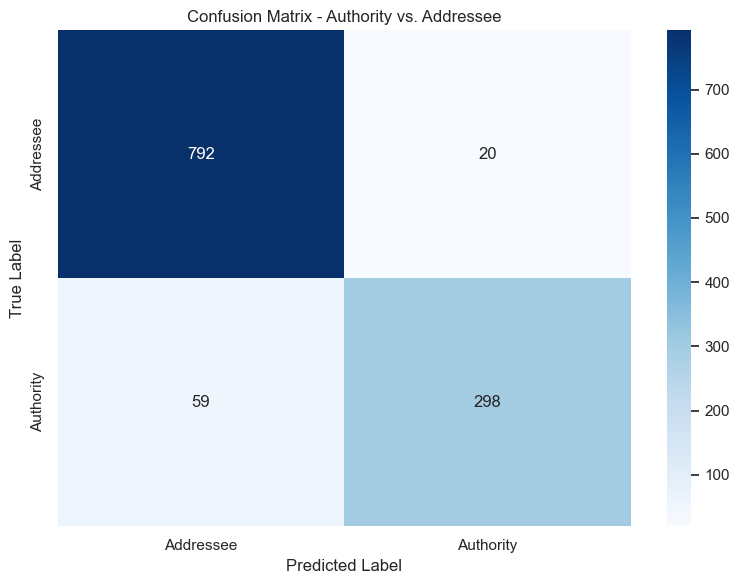

In [85]:
# Prepare data for binary classification (Authority vs. Addressee)
X_train = train_df['processed_text']
X_test = test_df['processed_text']
y_train = train_df['is_authority']
y_test = test_df['is_authority']

# Create a pipeline with TF-IDF vectorization and classifier
binary_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('classifier', LogisticRegression(C=1, max_iter=1000, random_state=42))
])

# Train the model
print("Training Authority vs. Addressee binary classifier...")
binary_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = binary_pipeline.predict(X_test)

print("\nAuthority vs. Addressee Classification Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Addressee', 'Authority']))

# Display confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Addressee', 'Authority'],
            yticklabels=['Addressee', 'Authority'])
plt.title('Confusion Matrix - Authority vs. Addressee')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 5.2 Multi-class Classification (All Seven Actor Tags)

Training multi-class classifier for all seven actor tags...

Multi-class Classification Results:
Accuracy: 0.6476

Classification Report:
                       precision    recall  f1-score   support

    Addressee_default       0.63      0.93      0.75       416
  Addressee_monitored       0.00      0.00      0.00        97
   Addressee_resource       1.00      0.04      0.07        28
     Addressee_sector       0.83      0.78      0.81       271
    Authority_default       0.63      0.27      0.38       180
Authority_legislative       0.45      0.73      0.56        45
 Authority_monitoring       0.50      0.58      0.54       132

             accuracy                           0.65      1169
            macro avg       0.58      0.48      0.44      1169
         weighted avg       0.61      0.65      0.60      1169



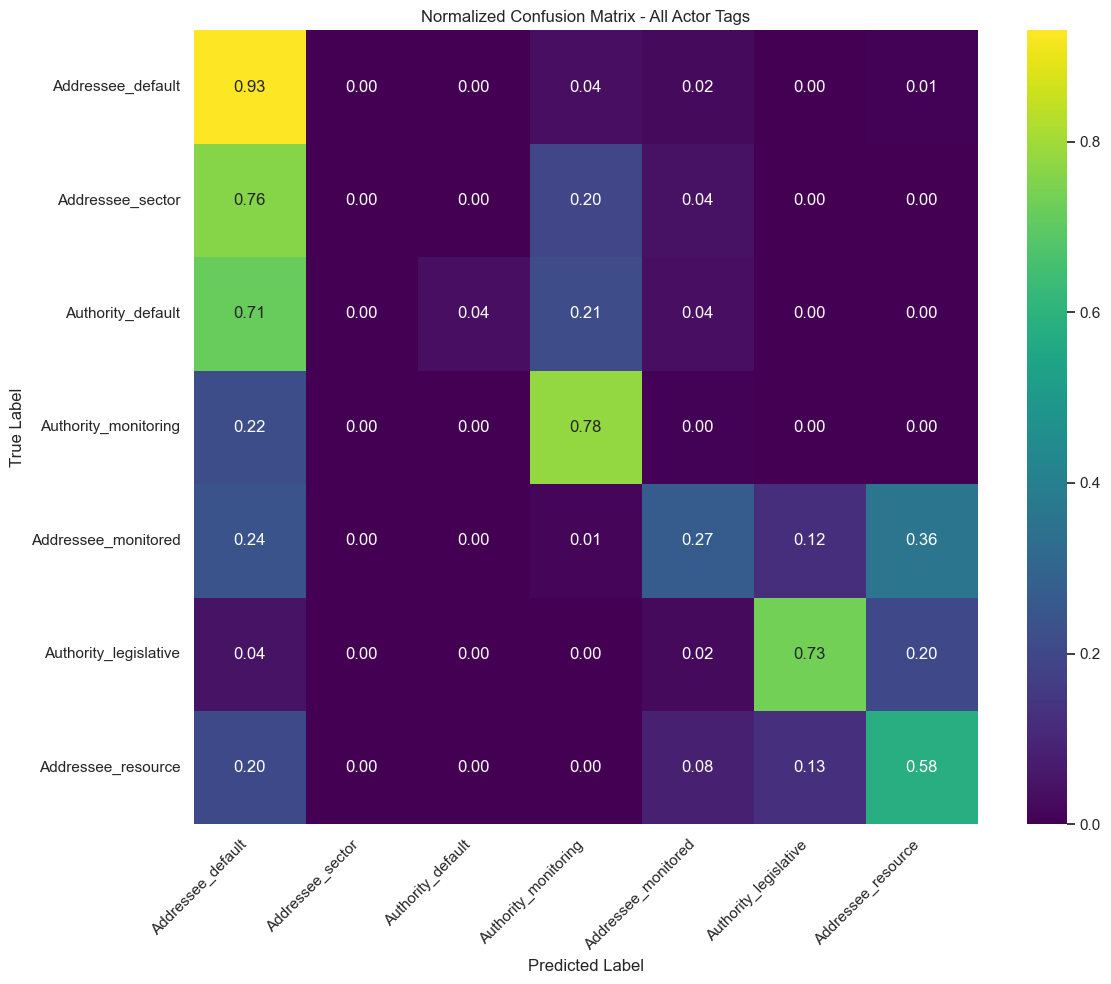

In [ ]:
# Prepare data for multi-class classification (all seven tag types)
y_train_multi = train_df['tag']
y_test_multi = test_df['tag']

# Create a pipeline with TF-IDF vectorization and classifier
multi_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 3))),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42))
])

# Train the model
print("Training multi-class classifier for all seven actor tags...")
multi_pipeline.fit(X_train, y_train_multi)

# Evaluate the model
y_pred_multi = multi_pipeline.predict(X_test)

print("\nMulti-class Classification Results:")
print(f"Accuracy: {accuracy_score(y_test_multi, y_pred_multi):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_multi, y_pred_multi))

# Display confusion matrix (with normalized values)
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test_multi, y_pred_multi, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='viridis',
            xticklabels=sufficient_tags,
            yticklabels=sufficient_tags)
plt.title('Normalized Confusion Matrix - All Actor Tags')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 5.3 Sector-Specific Classification

Training sector-specific classifier...

Sector Classification Results:
Accuracy: 0.9127

Classification Report:
              precision    recall  f1-score   support

  Non-Sector       0.95      0.94      0.94       898
      Sector       0.80      0.83      0.82       271

    accuracy                           0.91      1169
   macro avg       0.87      0.88      0.88      1169
weighted avg       0.91      0.91      0.91      1169



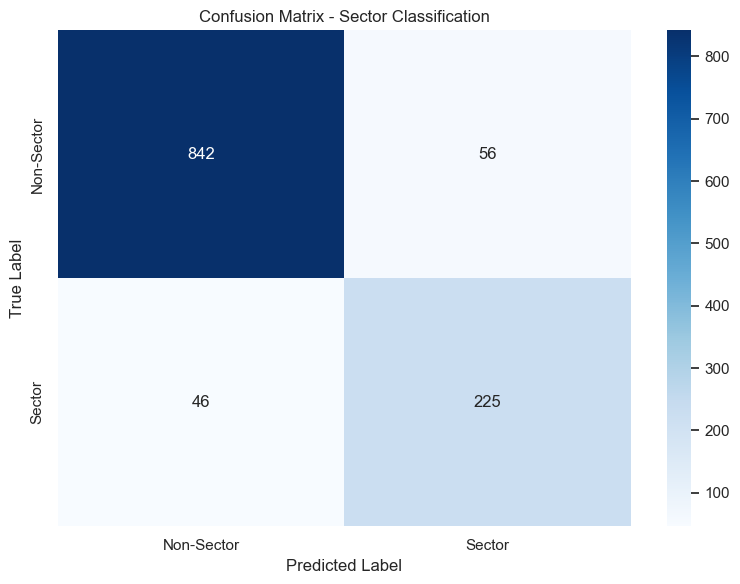

In [87]:
# Prepare data for sector-specific classification
X_train_sector = train_df['processed_text']
X_test_sector = test_df['processed_text']
y_train_sector = train_df['is_sector']
y_test_sector = test_df['is_sector']

# Create a pipeline with TF-IDF vectorization and classifier
sector_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('classifier', LogisticRegression(C=10, max_iter=1000, random_state=42))
])

# Train the model
print("Training sector-specific classifier...")
sector_pipeline.fit(X_train_sector, y_train_sector)

# Evaluate the model
y_pred_sector = sector_pipeline.predict(X_test_sector)

print("\nSector Classification Results:")
print(f"Accuracy: {accuracy_score(y_test_sector, y_pred_sector):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_sector, y_pred_sector, target_names=['Non-Sector', 'Sector']))

# Display confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_sector, y_pred_sector)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Sector', 'Sector'],
            yticklabels=['Non-Sector', 'Sector'])
plt.title('Confusion Matrix - Sector Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

Let's analyze which features are most important for our classification models.

Comparing different classifiers for actor tag classification:

Training Logistic Regression...
Logistic Regression Accuracy: 0.6681

Training Random Forest...
Random Forest Accuracy: 0.6621

Training Linear SVM...
Linear SVM Accuracy: 0.6698


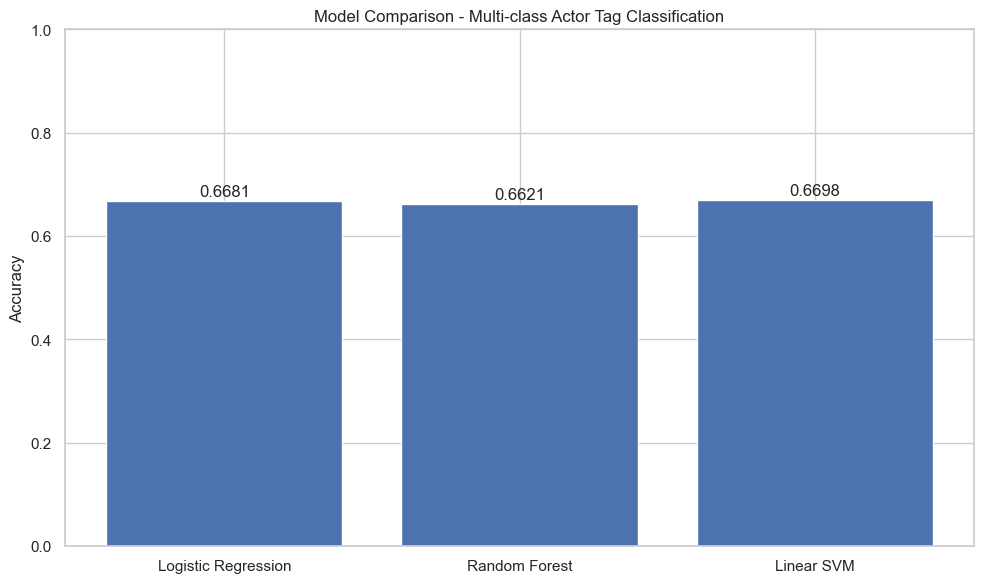

In [88]:
# Compare different classifiers for multi-class classification
classifiers = {
    'Logistic Regression': LogisticRegression(C=1, max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Linear SVM': LinearSVC(C=1, max_iter=10000, random_state=42)
}

# Vectorize the text once
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Compare models
results = {}

print("Comparing different classifiers for actor tag classification:")
for name, classifier in classifiers.items():
    print(f"\nTraining {name}...")
    try:
        classifier.fit(X_train_vec, y_train_multi)
        y_pred = classifier.predict(X_test_vec)
        accuracy = accuracy_score(y_test_multi, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")
    except Exception as e:
        print(f"Error training {name}: {e}")
        results[name] = 0

# Visualize comparison
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.ylim([0, 1.0])
plt.title('Model Comparison - Multi-class Actor Tag Classification')
plt.ylabel('Accuracy')
for i, (name, accuracy) in enumerate(results.items()):
    plt.text(i, accuracy + 0.01, f'{accuracy:.4f}', ha='center')
plt.tight_layout()
plt.show()


Top 20 most important features:
          Feature  Importance
0      commission    0.110025
1          member    0.043971
2          states    0.038609
3   member states    0.034554
4         council    0.032558
5          system    0.019203
6       customers    0.016131
7       committee    0.015888
8    transmission    0.015142
9        european    0.015075
10      authority    0.014004
11   manufacturer    0.013612
12       supplier    0.012975
13      suppliers    0.012516
14   member state    0.011972
15     parliament    0.011517
16      operators    0.011454
17       operator    0.011144
18      transport    0.010438
19          state    0.010371


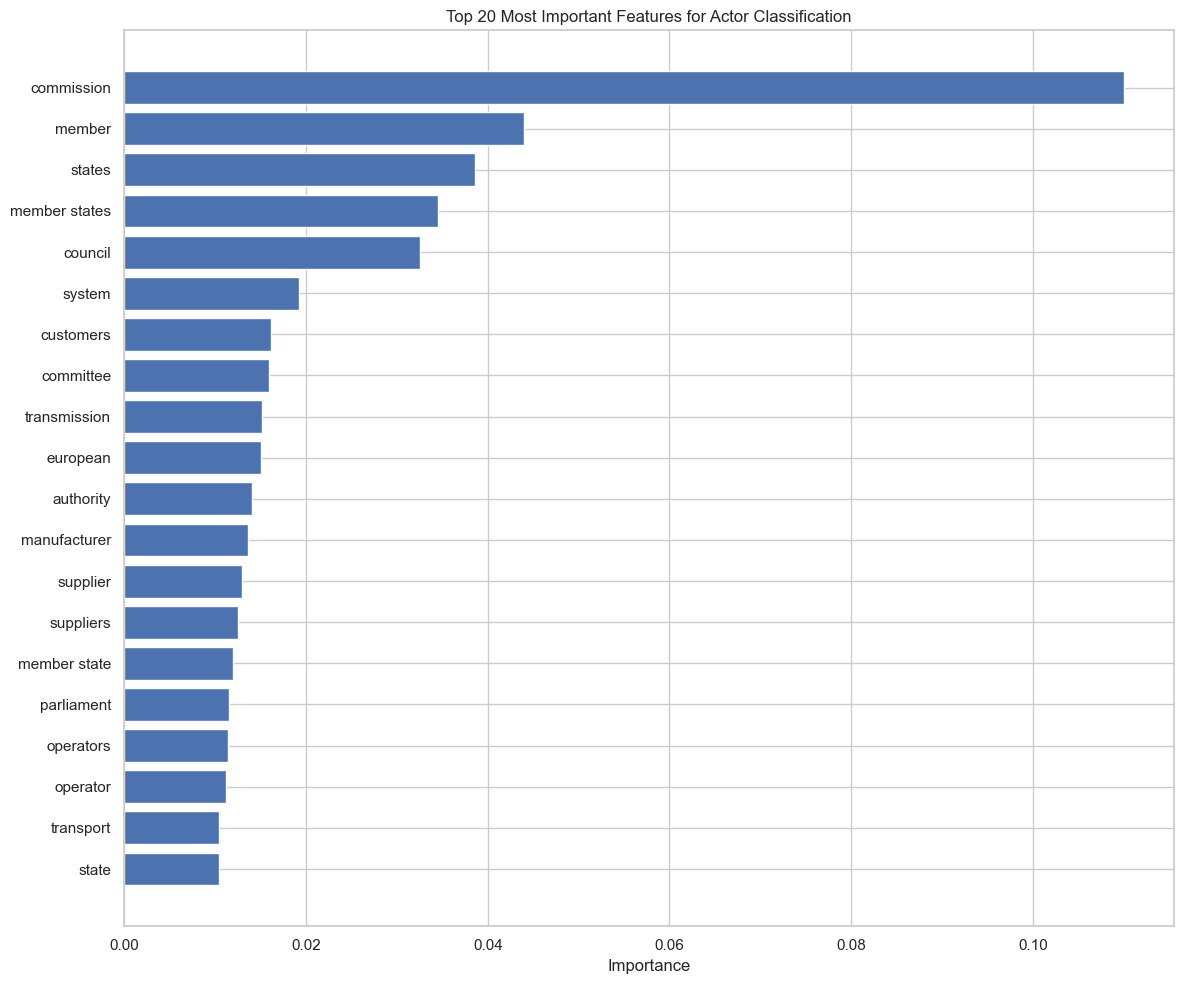

In [89]:
# Extract feature importance
if 'Random Forest' in classifiers and results['Random Forest'] > 0:
    # Get feature names from TF-IDF vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Get the Random Forest model
    rf_model = classifiers['Random Forest']
    
    # Get feature importance
    importances = rf_model.feature_importances_
    
    # Sort feature importance in descending order
    indices = importances.argsort()[::-1]
    top_n = 20
    
    # Create DataFrame for most important features
    top_features = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices[:top_n]],
        'Importance': [importances[i] for i in indices[:top_n]]
    })
    
    # Display and plot top features
    print("\nTop 20 most important features:")
    print(top_features)
    
    plt.figure(figsize=(12, 10))
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Importance')
    plt.title('Top 20 Most Important Features for Actor Classification')
    plt.gca().invert_yaxis()  # Invert y-axis to have most important feature at the top
    plt.tight_layout()
    plt.show()

## 7. Full Actor Tagging Pipeline

Now we'll build an integrated pipeline that combines NER and classification models to extract and categorize actors from EU climate policy text.

In [91]:
# Create an integrated pipeline for actor tag extraction and classification
def analyze_policy_text(text):
    """Complete pipeline for actor tag extraction and classification"""
    results = {
        'text': text,
        'entities': [],
        'classifications': []
    }
    
    # Step 1: Extract entities using the NER model
    doc = trained_ner(text)
    
    for ent in doc.ents:
        # Step 2: For each entity, classify it using the appropriate model
        entity_text = ent.text
        
        # Make predictions
        if ent.label_ == 'AUTHORITY' or ent.label_ == 'ADDRESSEE':
            # Use multi-class classifier for more specific categorization
            tag_prediction = multi_pipeline.predict([entity_text])[0]
        elif ent.label_ == 'SECTOR':
            # For sectors, we know it's Addressee_sector
            tag_prediction = 'Addressee_sector'
        else:
            # Use binary classifier first to determine authority vs. addressee
            is_authority = binary_pipeline.predict([entity_text])[0]
            tag_prediction = "Unknown_" + ("Authority" if is_authority else "Addressee")
        
        entity_info = {
            'text': entity_text,
            'label': ent.label_,
            'start': ent.start_char,
            'end': ent.end_char,
            'predicted_tag': tag_prediction
        }
        
        results['entities'].append(entity_info)
        results['classifications'].append(tag_prediction)
    
    return results

# Test the integrated pipeline on a few examples
test_examples = [
    test_df['context'].iloc[0],  # First test example
    test_df['context'].iloc[10] if len(test_df) > 10 else test_df['context'].iloc[0],  # Another test example
    test_df['context'].iloc[20] if len(test_df) > 20 else test_df['context'].iloc[0]   # A third test example
]

print("Testing the integrated actor tag extraction and classification pipeline:")
for i, text in enumerate(test_examples):
    print(f"\nExample {i+1}:")
    results = analyze_policy_text(text)
    
    print(f"Text: '{text[:100]}...'")
    print("\nEntities and Classifications:")
    for entity in results['entities']:
        print(f"  - '{entity['text']}' - {entity['predicted_tag']}")
        
    # Visualize the entities in the text
    doc = trained_ner(text)
    displacy.render(doc, style="ent", jupyter=True)

Testing the integrated actor tag extraction and classification pipeline:

Example 1:
Text: 'e date of receipt of the request.
3.   where the regulatory authority which has taken the decision ...'

Entities and Classifications:
  - 'regulatory authority' - Authority_default



Example 2:
Text: 'nnex iii.
3.   on request from the commission, a member state shall also transmit the full set of d...'

Entities and Classifications:



Example 3:
Text: ' listed in annex i to directive 2003/87/ec of the european parliament and of the council of 13 octob...'

Entities and Classifications:
  - 'european parliament' - Authority_legislative
  - 'council of 13' - Authority_legislative


In [97]:
# Save models, vectorizers and training data
import os
import pickle

def save_model(model, filename, directory='./classification'):
    """Save a model or other object to pickle file with error handling."""
    try:
        os.makedirs(directory, exist_ok=True)
        filepath = os.path.join(directory, filename)
        with open(filepath, 'wb') as f:
            pickle.dump(model, f)
        return True
    except Exception as e:
        print(f"Error saving {filename}: {e}")
        return False

# Extract vectorizers
tfidf_vectorizer = binary_pipeline.named_steps['tfidf']
count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
count_vectorizer.fit(X_train)

# Save all models and vectorizers
saved_files = []
models_to_save = {
    'tfidf_vectorizer.pkl': tfidf_vectorizer,
    'count_vectorizer.pkl': count_vectorizer,
    'binary_classifier.pkl': binary_pipeline,
    'multiclass_classifier.pkl': multi_pipeline,
    'sector_classifier.pkl': sector_pipeline,
}

# Save models and vectorizers
for filename, model in models_to_save.items():
    if save_model(model, filename):
        saved_files.append(filename)

# Save training/test data if available
if 'y_train' in locals():
    training_data = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
    if save_model(training_data, 'train_test_data.pkl'):
        saved_files.append('train_test_data.pkl')
else:
    # Unsupervised case
    training_data = {
        'X_train': X_train,
        'X_test': X_test
    }
    if save_model(training_data, 'train_test_data_unsupervised.pkl'):
        saved_files.append('train_test_data_unsupervised.pkl')

# Report success
print(f"Successfully saved {len(saved_files)} files:")
for filename in saved_files:
    print(f"- ../data/processed/{filename}")

Successfully saved 6 files:
- ../data/processed/tfidf_vectorizer.pkl
- ../data/processed/count_vectorizer.pkl
- ../data/processed/binary_classifier.pkl
- ../data/processed/multiclass_classifier.pkl
- ../data/processed/sector_classifier.pkl
- ../data/processed/train_test_data.pkl
